# Финальный проект специализации "Машинное обучение и анализ данных"
## Прогнозирование оттока клиентов
*Динара Мухтарова*

### Цели и задачи проекта

В проекте используются данные французской телекоммуникационной компании Orange. В рамках проекта решается задача прогнозирования оттока пользователей, или churn prediction. Эта задача заключается в прогнозировании вероятности того, что клиент перестанет пользоваться сервисом в течение некоторого заданного заранее промежутка времени, например, решит перейти к конкуренту или откажется от использования услуги данного типа вообще.

Цель проекта - научиться находить пользователей, склонных к оттоку. Если научиться находить таких пользователей с достаточной точностью заблаговременно, то можно эффективно управлять оттоком: например, выявлять причины оттока; помогать пользователям, попавшим в группу риска, решать их проблемы и задачи; проводить кампании по удержанию.

Для нахождения пользователей, склонных к оттоку, мы строим прогнозную модель - модель, позволяющую прогнозировать вероятность того, что пользователь покинет сервис. Конкретно мы строим вероятностную модель бинарной классификации, где целевой класс представляют собой пользователи, покидающие сервис. Вероятность того, что пользователь принадлежит целевому классу и есть целевая величина - вероятность оттока. Соответственно, чем эта вероятность больше, тем больше шансов, что пользователь откажется от использования нашего сервиса.

### Методика измерения качества и критерий успеха

Модель оценивается на основании метрики AUC-ROC - площади под ROC-кривой. Для тестирования модели мы используем метод кросс-валидации - разбиваем выборку на три блока, каждый из которых по очереди выступает как тестовый. Так как классы в исходной выборке несбалансированы, используем стратификацию - разбиваем выборку так, чтобы в каждом блоке сохранялось соотношение классов. Чем выше показатель AUC-ROC, тем качественнее классификатор, при этом значение 0.5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию).

### Техническое описание решения 

Данные, с которыми мы работаем, предоставлены без описания, однако известно, что они состоят из 40 тыс. объектов и включают 230 переменных, из которых первые 190 переменных - числовые, а оставшиеся 40 - категориальные. Ещё одной особенностью нашего набора данных является большое количество пропущенных значений. Прежде чем строить модель, мы сначала предобрабатываем данные: преобразовываем категориальные переменные в числовые, заполняем пропущенные значения и проводим другие преобразования, позволяющие нам улучшить качество модели.

Загружаем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

Загружаем данные.

In [2]:
data = pd.read_csv('orange_small_churn_train_data.csv', index_col = 0)

Получаем списки числовых и категориальных переменных.

In [3]:
numeric_columns = np.array(data.columns[:190])
categorical_columns = np.array(data.columns[190:230])

Для построения модели выбираем только те переменные, в которых есть хотя бы одно значение, не равное NaN.

In [4]:
not_null_numeric_columns = np.array(numeric_columns[np.array(pd.notnull(data[numeric_columns]).any())])
not_null_categorical_columns = np.array(categorical_columns[np.array(pd.notnull(data[categorical_columns]).any())])

Разбиваем данные на числовые, категориальные и целевую переменную - метки классов "отток"/"не отток".

In [5]:
X_numeric = data[not_null_numeric_columns]
X_categorical = data[not_null_categorical_columns]
y = data['labels']

Заполняем пропущенные числовые значения средними по столбцам, а пропущенные категориальные - строкой 'NA'.

In [6]:
X_numeric = X_numeric.fillna(X_numeric.mean(0), axis = 0)
X_categorical = X_categorical.fillna('NA')

Кодируем категориальные признаки частотами: каждую категорию преобразуем в число раз, которое она встречалась в данном признаке.

In [7]:
for var in not_null_categorical_columns:
    value_counts = X_categorical[var].value_counts()
    X_categorical[var] = np.array([value_counts[x] for x in X_categorical[var]])

Объединяем числовые и категориальные данные.

In [8]:
X = pd.concat([X_numeric, X_categorical], axis = 1)

Для построения модели используем градиентный бустинг, реализацию `xgboost.XGBClassifier`. Обучаем модель на наших данных.

In [9]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Выводы о качестве модели

Оцениваем качество с помощью кросс-валидации и считаем среднюю AUC-ROC.

In [10]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
scores = cross_val_score(xgb.XGBClassifier(), X, y, scoring = 'roc_auc', cv = StratifiedKFold(3))
print 'Средняя AUC-ROC: ', scores.mean()

Средняя AUC-ROC:  0.744447036908


Видим, что средняя AUC-ROC равна 0.74. Это означает, что модель работает существенно лучше, чем случайное угадывание.

Строим кривые обучения - постепенно наращиваем размер обучающей выборки и смотрим, как меняется качество на обучающей и тестовой выборках.

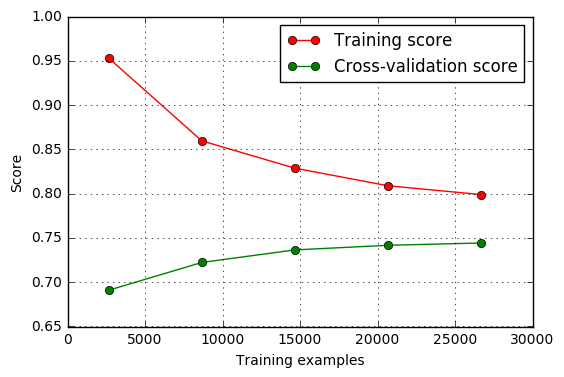

In [11]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline
train_sizes_abs, train_scores, test_scores = learning_curve(xgb.XGBClassifier(), X, y, cv = StratifiedKFold(3),
                                                            scoring = 'roc_auc')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.figure()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color = 'r', label = 'Training score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.legend(loc = 'best')
plt.show()

Видим, что с увеличением размера данных качество на тестовой выборке (Cross-validation score) увеличивается, а на обучающей (Training score) сокращается. Значит, в дальнейшем можно пробовать наращивать размер данных для увеличения качества.

Перечисляем двадцать лучших признаков и считаем вклад каждого из них в модель.

In [12]:
features = pd.DataFrame({'feature' : X.columns, 'feature_importance' : xgb_clf.feature_importances_})
features.sort_values('feature_importance', ascending = False).reset_index(drop = True)[:20]

,feature,feature_importance
0,Var126,0.144105
1,Var217,0.069869
2,Var189,0.059680
3,Var199,0.058224
4,Var192,0.053857
5,Var113,0.046579
6,Var73,0.046579
7,Var81,0.040757
8,Var74,0.034934
9,Var57,0.032023


Видим, что наибольший вклад в модель внесли признаки Var126, Var217, Var189. Замыкает топ-20 признак Var45.

### Ожидаемый экономический эффект от использования модели

Для подсчёта экономического эффекта от использования модели вводим следующие параметры:
- количество денег, которое в среднем приносит один пользователь в месяц (arpu)
- количество денег, которое в среднем мы будем вкладывать в удержание одного пользователя (retention cost)
- вероятность, с которой пользователь примет наше предложение (probability)
- топ % пользователей, склонных к оттоку согласно модели, которые будут участвовать в кампании (top)
- количество времени, на которое нам в среднем удастся удержать клиента, если он примет наше предложение, в месяцах (time)

Экономический эффект зависит от того, насколько качественная наша модель. Выбираем только тех пользователей, которых наша модель предсказала как склонных к оттоку, и записывам в переменную `true_values` настоящие ответы на этих пользователях.

In [13]:
y_predictions = xgb_clf.predict(X)
y_probabilities = xgb_clf.predict_proba(X)[:, 1]
labels = pd.DataFrame({'prediction' : y_predictions, 'probability' : y_probabilities, 'true_value' : np.array(y)})
churn_predicted = labels[labels.prediction == 1].sort_values('probability', ascending = False).reset_index(drop = True)
true_values = np.array(churn_predicted.true_value)

Определяем функцию для подсчёта экономического эффекта в зависимости от исходных параметров.

In [14]:
def effect(arpu, retention_cost, probability, top, time):
    number_of_users = int(np.floor(top/100. * len(true_values)))
    number_of_churned = sum(true_values[:number_of_users] == 1)
    number_of_accepted = int(np.floor(probability * number_of_churned))
    cost = number_of_users * retention_cost
    income = number_of_accepted * arpu * time
    return income - cost

Фиксируем параметры arpu = 1000, retention cost = 100, probability = 0.3, time = 3 и строим график изменения экономического эффекта в зависимости от параметра top.

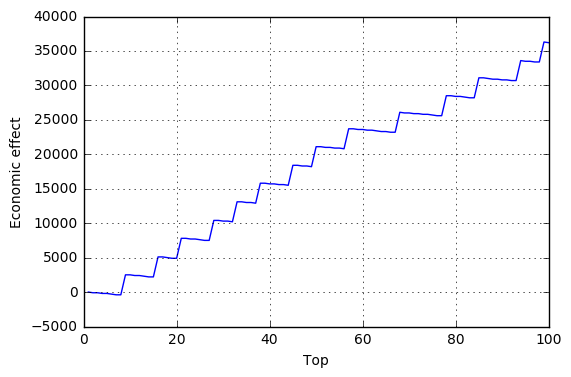

In [15]:
tops = np.arange(1, 101)
effects = np.array([effect(1000, 100, 0.3, top, 3) for top in tops])
plt.figure()
plt.xlabel('Top')
plt.ylabel('Economic effect')
plt.grid()
plt.plot(tops, effects)
plt.show()

Видим, что чем больше топ пользователей, который мы берём, тем в среднем выше экономический эффект. Это говорит о том, что модель качественная. Считаем оптимальный топ пользователей при таких параметрах и экономический эффект при нём.

In [16]:
index = np.argsort(effects)[-1]
print 'Оптимальный топ: ', tops[index]
print 'Экономический эффект: ', effects[index]

Оптимальный топ:  99
Экономический эффект:  36300


### Дальнейшие предложения

1. Для оценки качества работы модели в продакшн можно использовать A/B-тестирование. Для этого нужно разбить всех пользователей на два сегмента: контрольный сегмент A (где мы используем старую модель прогнозирования оттока или не используем никакую модель вообще) и тестовый сегмент B (где мы используем нашу новую модель), и сравнить уровни оттока у этих двух сегментов. Если уровень оттока у сегмента B меньше, чем у сегмента A, и отличие статистически значимо, то мы можем сказать, что наша модель работает.
2. Для того, чтобы повышать качество работы модели, нужно дообучать её на новых данных. Также можно пробовать изменять саму модель - использовать новые алгоритмы, отбирать признаки, искать аномалии в данных и т.д.
3. Нужно следить за тем, чтобы модель всегда оставалась актуальной, - со временем могут появиться новые услуги, а старые исчезнуть, и наши данные устареют.
4. Можно пробовать формировать гипотезы относительно причин оттока пользователей, и на основании этого принимать меры по удержанию.

### Итог

Построена модель, позволяющая прогнозировать вероятность того, что пользователь покинет сервис. В дальнейшем эти данные можно использовать для выявления пользователей, склонных к оттоку, и принимать меры по их удержанию.